# Churn

## 1 - Import useful modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

## 2 - Load and prepare dataset

In [2]:
x_train = pd.read_csv('data/bank_data_train.csv', index_col='ID')

y_train = x_train.pop('TARGET')

Lower case categorical columns to avoid duplicates.

In [3]:
categorical_train = x_train.select_dtypes(include=["object_"])
categorical_cols = categorical_train.columns
categorical_train = categorical_train.apply(lambda c: c.str.lower())

categorical_train.describe()

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK
count,69421,68234,59361,44781,210811,57257,68104,57257,57256,60545,67362,67362,355190
unique,20,8,5,4,15111,2,12,2,2,4,4,4,12
top,friend,m,so,specialist,директор,n,h,n,n,specialist,private,private,102
freq,24896,32185,28056,25123,24974,36332,44370,52750,32843,36622,59087,59087,116986


Deal with duplicates in the `CLNT_TRUST_RELATION` column by translating Russian terms to their equivalent in English.

In [4]:
ru_to_en = {'друг': 'other', 'мать': 'mother', 'брат': 'brother', 'отец': 'father', 'сестра': 'sister', 'дочь': 'daughter', 'сын': 'son', 'мама': 'mother'}
categorical_train['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)

In [5]:
for c in categorical_cols:
    print("-" * 80)
    print(categorical_train[c].value_counts())

--------------------------------------------------------------------------------
friend        24896
mother        11172
relative       8207
other          6850
brother        5620
sister         5583
father         3056
daughter       2032
son            1947
близкий ро       44
дальний ро        6
муж               5
жена              3
Name: CLNT_TRUST_RELATION, dtype: int64
--------------------------------------------------------------------------------
m    32185
v    23075
d     7777
t     3392
n      936
w      697
c      155
        17
Name: APP_MARITAL_STATUS, dtype: int64
--------------------------------------------------------------------------------
so         28056
jo         14153
other      11316
rent        3223
nprivat     2613
Name: APP_KIND_OF_PROP_HABITATION, dtype: int64
--------------------------------------------------------------------------------
specialist     25123
manager         9396
top_manager     7262
self_empl       3000
Name: CLNT_JOB_POSITION_TYPE, dt

In [6]:
x_train[categorical_cols] = categorical_train

Split the training set into a train dataset (80%) and a dev set (20%) with stratification.

In [7]:
X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=1337)

del(x_train)
del(y_train)
del(categorical_train)

Fill NA values.

In [8]:
X_train.isna().sum()

CR_PROD_CNT_IL                   0
AMOUNT_RUB_CLO_PRC           30587
PRC_ACCEPTS_A_EMAIL_LINK    160064
APP_REGISTR_RGN_CODE        235888
PRC_ACCEPTS_A_POS           160064
                             ...  
LDEAL_DELINQ_PER_MAXYWZ     207411
TURNOVER_DYNAMIC_CC_3M           0
LDEAL_ACT_DAYS_PCT_TR       209198
LDEAL_ACT_DAYS_PCT_TR4      209198
LDEAL_ACT_DAYS_PCT_CURR     209198
Length: 114, dtype: int64

In [9]:
medians = X_train.median(numeric_only=True)
X_train.fillna(medians, inplace=True)
X_dev.fillna(medians, inplace=True)

## 3 - Baseline - naive classifier

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [11]:
class Baseline:
    def __init__(self) -> None:
        self.prediction = 0

    def fit(self, X, y):
        classes = set(y)
        frequencies = {cls: (Y_train == cls).sum() for cls in classes}
        self.prediction = max(frequencies, key=frequencies.get)

    def predict(self, X):
        return np.full(X.shape[0], self.prediction)

In [12]:
bsl = Baseline()
bsl.fit(X_train, Y_train)
dev_predictions = bsl.predict(X_dev)

In [13]:
accuracy_score(Y_dev, dev_predictions)

0.918564711844365

In [14]:
roc_auc_score(Y_dev, dev_predictions)

0.5

## 4 - Baseline - random forest

Label-encode categorical features.

In [15]:
X_train_categorical = pd.concat([X_train.pop(col) for col in categorical_cols], axis=1)
X_dev_categorical = pd.concat([X_dev.pop(col) for col in categorical_cols], axis=1)
X_train_categorical_encoded = X_train_categorical.astype(pd.CategoricalDtype())
X_dev_categorical_encoded = pd.DataFrame()

In [16]:
for col in categorical_cols:
    categories = X_train_categorical_encoded[col].cat.categories
    X_dev_categorical_encoded[col] = X_dev_categorical[col].astype(pd.CategoricalDtype(categories=categories))
    X_train_categorical_encoded[col] = X_train_categorical_encoded[col].cat.codes
    X_dev_categorical_encoded[col] = X_dev_categorical_encoded[col].cat.codes

In [17]:
X_train = pd.concat([X_train, X_train_categorical_encoded], axis=1)
X_dev = pd.concat([X_dev, X_dev_categorical_encoded], axis=1)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
parameter_grid = {'n_estimators': [16, 32],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [8, 16, 32, 64]}

rfc = RandomForestClassifier(random_state=1337)
grid_search = GridSearchCV(estimator=rfc, param_grid=parameter_grid, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 2/3] END max_depth=8, max_features=sqrt, n_estimators=16;, score=0.919 total time=  13.2s
[CV 1/3] END max_depth=8, max_features=sqrt, n_estimators=16;, score=0.919 total time=  13.6s
[CV 3/3] END max_depth=8, max_features=sqrt, n_estimators=16;, score=0.919 total time=  13.7s
[CV 1/3] END max_depth=8, max_features=log2, n_estimators=16;, score=0.919 total time=   6.2s
[CV 1/3] END max_depth=8, max_features=sqrt, n_estimators=32;, score=0.919 total time=  21.5s
[CV 2/3] END max_depth=8, max_features=log2, n_estimators=16;, score=0.919 total time=   6.2s
[CV 3/3] END max_depth=8, max_features=log2, n_estimators=16;, score=0.919 total time=   6.1s
[CV 2/3] END max_depth=8, max_features=sqrt, n_estimators=32;, score=0.919 total time=  16.9s
[CV 3/3] END max_depth=8, max_features=sqrt, n_estimators=32;, score=0.919 total time=  17.5s
[CV 1/3] END max_depth=8, max_features=log2, n_estimators=32;, score=0.919 total time=  12.5s

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1337),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 32, 64],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [16, 32]},
             verbose=3)

In [21]:
best_rfc = grid_search.best_estimator_

In [24]:
dev_predictions = best_rfc.predict(X_dev)

In [25]:
accuracy_score(Y_dev, dev_predictions)

0.919296714434528

In [26]:
roc_auc_score(Y_dev, dev_predictions)

0.5115047287321428

In [27]:
train_predictions = best_rfc.predict(X_train)

In [28]:
accuracy_score(Y_train, train_predictions)

0.9771565922464034

In [29]:
roc_auc_score(Y_train, train_predictions)

0.8597844142209274

## 5 - MLPClassifier

One-hot encode categorical features.

In [30]:
X_train_categorical

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK
ID,,,,,,,,,,,,,
568142,sister,t,jo,specialist,апоратчик,n,h,n,y,specialist,private,private,103
581309,NaN,NaN,NaN,NaN,руководитель сектора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107
571905,NaN,NaN,NaN,NaN,мл. научный сотрудник,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
391700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,k01
487431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105
198702,NaN,NaN,NaN,NaN,директор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
322749,NaN,NaN,NaN,NaN,зам.директора по персоналу,NaN,NaN,NaN,NaN,NaN,NaN,NaN,k01


In [31]:
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False, max_categories=1000)
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical)
X_dev_categorical_encoded = encoder.transform(X_dev_categorical)

In [32]:
X_train.drop(columns=categorical_cols, inplace=True)
X_dev.drop(columns=categorical_cols, inplace=True)

In [33]:
del(X_train_categorical)
del(X_dev_categorical)

In [34]:
X_train = X_train.to_numpy()
X_dev = X_dev.to_numpy()
Y_train = Y_train.to_numpy()
Y_dev = Y_dev.to_numpy()

In [35]:
X_train = np.concatenate((X_train, X_train_categorical_encoded), axis=1)
X_dev = np.concatenate((X_dev, X_dev_categorical_encoded), axis=1)

In [36]:
del(X_train_categorical_encoded)
del(X_dev_categorical_encoded)

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
mlp = MLPClassifier(random_state=1337, verbose=True, hidden_layer_sizes=(100, 100))
mlp.fit(X_train, Y_train)

Iteration 1, loss = 3.07581885
Iteration 2, loss = 1.26960677
Iteration 3, loss = 0.55466725
Iteration 4, loss = 0.31832247
Iteration 5, loss = 0.29596984
Iteration 6, loss = 0.28432089
Iteration 7, loss = 0.28442767
Iteration 8, loss = 0.28263402
Iteration 9, loss = 0.28231132
Iteration 10, loss = 0.28232453
Iteration 11, loss = 0.28232239
Iteration 12, loss = 0.28232547
Iteration 13, loss = 0.28236213
Iteration 14, loss = 0.28233516
Iteration 15, loss = 0.28295997
Iteration 16, loss = 0.28264172
Iteration 17, loss = 0.28241162
Iteration 18, loss = 0.28241003
Iteration 19, loss = 0.28260493
Iteration 20, loss = 0.28272246
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(100, 100), random_state=1337, verbose=True)

In [39]:
mlp.score(X_dev, Y_dev)

0.9185224809257018

In [40]:
dev_predictions = mlp.predict(X_dev)
accuracy_score(Y_dev, dev_predictions)

0.9185224809257018

In [41]:
roc_auc_score(Y_dev, dev_predictions)

0.49997701255114707

## 6 - Keras

In [42]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-05-25 23:29:58.101214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
input_shape = [X_train.shape[1]]
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=input_shape),
    layers.Dense(100, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

2023-05-25 23:30:12.329981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [60]:
history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=2, batch_size=512)

Epoch 1/2
555/555 [==============================] - 7s 13ms/step - loss: 0.2823 - binary_accuracy: 0.9186 - val_loss: 0.2823 - val_binary_accuracy: 0.9186
Epoch 2/2
555/555 [==============================] - 6s 11ms/step - loss: 0.2823 - binary_accuracy: 0.9186 - val_loss: 0.2823 - val_binary_accuracy: 0.9186


<Axes: >

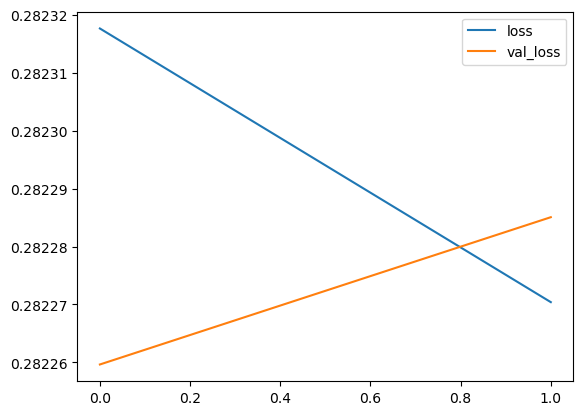

In [61]:
history = pd.DataFrame(history.history)
history[['loss', 'val_loss']].plot()

## 7 - TensorFlow

## 8 - Numpy

## n - Make predictions on the test set

In [32]:
del(X_train)
del(X_dev)
del(Y_train)
del(Y_dev)

In [33]:
x_test = pd.read_csv('data/bank_data_test.csv', index_col='ID')
x_test.drop(columns=['TARGET'], inplace=True)
idx = x_test.index

In [34]:
categorical_test = x_test.select_dtypes(include=["object_"])
categorical_test = categorical_test.apply(lambda c: c.str.lower())
categorical_test['CLNT_TRUST_RELATION'].replace(ru_to_en, inplace=True)

In [35]:
categorical_test_encoded = encoder.transform(categorical_test)
del(categorical_test)
x_test.drop(columns=categorical_cols, inplace=True)

In [36]:
x_test.fillna(medians, inplace=True)
x_test = x_test.to_numpy()
x_test = np.concatenate((x_test, categorical_test_encoded), axis=1)
del(categorical_test_encoded)

Save the final predictions to a csv file.

In [38]:
test_predictions = best_rfc.predict(x_test)
test_predictions = pd.DataFrame(test_predictions, index=idx, columns=['TARGET'])
test_predictions.to_csv('final_predictions.csv')